In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from my_functions import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
import optuna

from sklearn.metrics import classification_report, accuracy_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Preprocessing

In [8]:
stroke_df_with_features = pd.read_csv('healthcare_stroke_data_clean_with_features.csv')

In [9]:
X_feat = stroke_df_with_features.drop('stroke', axis=1)
y_feat = stroke_df_with_features['stroke']

X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42, stratify=y_feat)

X_train_feat.shape, X_test_feat.shape, y_train_feat.shape, y_test_feat.shape

((3927, 12), (982, 12), (3927,), (982,))

In [10]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols_feat = ['gender', 'hypertension', 'heart_disease', 
                         'ever_married', 'work_type', 'Residence_type', 
                         'smoking_status', 'bmi_category', 'age_group']

# Light GBM Model

In [11]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [12]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 20, 300, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 3, 25)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 1e-8, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 2, 500)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.4, 1.0)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.4, 1.0)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 5, 100)

    lgbm_model_pipeline.set_params(classifier__n_estimators=n_estimators, classifier__max_depth=max_depth)

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]

        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:11:08,417] A new study created in memory with name: no-name-fad36c91-7001-4f74-9faa-b4aa10b066d6
[I 2024-04-14 12:11:09,311] Trial 0 finished with value: -1.0 and parameters: {'classifier__n_estimators': 300, 'classifier__max_depth': 12, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.017982596935479336, 'classifier__lambda_l2': 0.2212443976164925, 'classifier__num_leaves': 131, 'classifier__feature_fraction': 0.7426930440043242, 'classifier__bagging_fraction': 0.7592846899442439, 'classifier__bagging_freq': 7, 'classifier__min_child_samples': 20}. Best is trial 0 with value: -1.0.
[I 2024-04-14 12:11:09,938] Trial 1 finished with value: -0.9911313000216309 and parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 15, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 8.322970484320535e-06, 'classifier__lambda_l2': 1.6799192261865563e-06, 'classifier__num_leaves': 355, 'classifier__feature_fraction': 0.8244098664972535, 'clas

{'classifier__n_estimators': 20, 'classifier__max_depth': 3, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 1.3918391609243649e-08, 'classifier__lambda_l2': 9.418551170989828, 'classifier__num_leaves': 15, 'classifier__feature_fraction': 0.5945370515468792, 'classifier__bagging_fraction': 0.4528538334887777, 'classifier__bagging_freq': 5, 'classifier__min_child_samples': 41} 0.2217587819036036


In [13]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [14]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.7841
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       940
           1       0.12      0.62      0.20        42

    accuracy                           0.78       982
   macro avg       0.55      0.71      0.54       982
weighted avg       0.94      0.78      0.85       982

[[744 196]
 [ 16  26]]


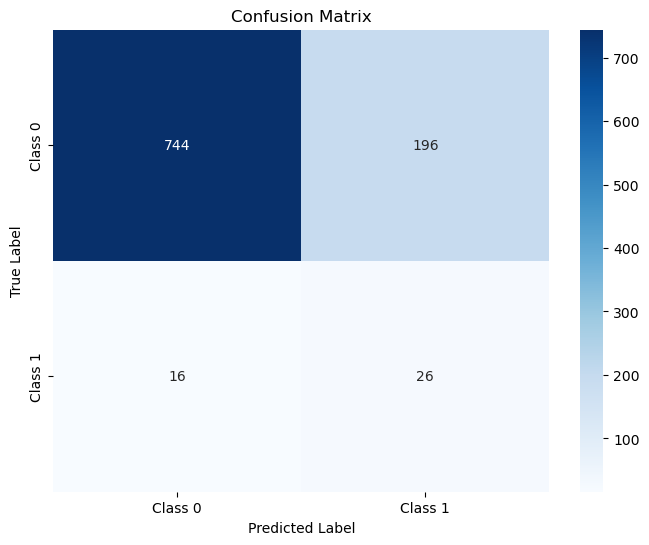

In [15]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

## With Smote - First set of numbers

In [16]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [17]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 20, 300, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 3, 25)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 1e-8, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 2, 500)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.4, 1.0)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.4, 1.0)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 5, 100)

    lgbm_model_pipeline.set_params(classifier__n_estimators=n_estimators, classifier__max_depth=max_depth)

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]

        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:11:41,214] A new study created in memory with name: no-name-b033945e-a18b-40cb-adb2-b59a9551e6f5
[I 2024-04-14 12:11:42,702] Trial 0 finished with value: -0.9970149253731343 and parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 4.7895904614448075e-05, 'classifier__lambda_l2': 0.3664676986485868, 'classifier__num_leaves': 49, 'classifier__feature_fraction': 0.42578555842846627, 'classifier__bagging_fraction': 0.911241669344037, 'classifier__bagging_freq': 6, 'classifier__min_child_samples': 84}. Best is trial 0 with value: -0.9970149253731343.
[I 2024-04-14 12:11:44,379] Trial 1 finished with value: -1.0 and parameters: {'classifier__n_estimators': 220, 'classifier__max_depth': 22, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 1.3523826074888446e-07, 'classifier__lambda_l2': 0.6076717704996353, 'classifier__num_leaves': 202, 'classifier__feature_fraction': 0.92329346254

{'classifier__n_estimators': 20, 'classifier__max_depth': 4, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.21384936623636494, 'classifier__lambda_l2': 5.91837491572965, 'classifier__num_leaves': 220, 'classifier__feature_fraction': 0.5615500802938704, 'classifier__bagging_fraction': 0.41929191512338854, 'classifier__bagging_freq': 6, 'classifier__min_child_samples': 44} 0.2746831076060158


In [18]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [19]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.8106
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       940
           1       0.13      0.60      0.21        42

    accuracy                           0.81       982
   macro avg       0.55      0.71      0.55       982
weighted avg       0.94      0.81      0.86       982

[[771 169]
 [ 17  25]]


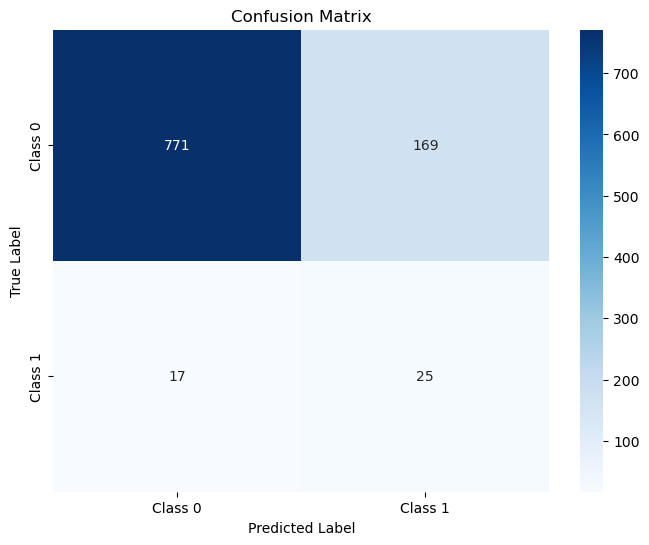

In [20]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

## Consequences of Smote

- The performance of Class 1 has stayed the same, however the model now makes less mistakes with Class 0 which is interesting. 

# Trying different numbers

In [21]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [22]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 20, 300, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 2, 25)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 1e-8, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 2, 500)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.4, 1.0)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.4, 1.0)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 20, 200)
    scale_pos_weight = trial.suggest_float('classifier__scale_pos_weight', 1, 100)
    learning_rate = trial.suggest_float('classifier__learning_rate', 0.01, 0.1)

    lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__boosting_type': boosting_type,
    'classifier__lambda_l1': lambda_l1,
    'classifier__lambda_l2': lambda_l2,
    'classifier__num_leaves': num_leaves,
    'classifier__feature_fraction': feature_fraction,
    'classifier__bagging_fraction': bagging_fraction,
    'classifier__bagging_freq': bagging_freq,
    'classifier__min_child_samples': min_child_samples,
    'classifier__scale_pos_weight': scale_pos_weight,
    'classifier__learning_rate': learning_rate
})

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]


        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:12:55,204] A new study created in memory with name: no-name-a43fc4bd-8538-4c2e-8cb0-4e8b583f9c6b
[I 2024-04-14 12:12:55,534] Trial 0 finished with value: -0.14454744732371955 and parameters: {'classifier__n_estimators': 60, 'classifier__max_depth': 16, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 4.316258813253377e-06, 'classifier__lambda_l2': 7.740669439029445e-06, 'classifier__num_leaves': 426, 'classifier__feature_fraction': 0.4443793277026538, 'classifier__bagging_fraction': 0.43102115780484873, 'classifier__bagging_freq': 5, 'classifier__min_child_samples': 41, 'classifier__scale_pos_weight': 75.7040223523374, 'classifier__learning_rate': 0.035893596046049255}. Best is trial 0 with value: -0.14454744732371955.
[I 2024-04-14 12:12:55,745] Trial 1 finished with value: -0.13184537685046654 and parameters: {'classifier__n_estimators': 140, 'classifier__max_depth': 5, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 9.203673606375327, 'cla

{'classifier__n_estimators': 40, 'classifier__max_depth': 2, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 5.008844383897367e-07, 'classifier__lambda_l2': 3.2637644392055403e-07, 'classifier__num_leaves': 261, 'classifier__feature_fraction': 0.6984991689155904, 'classifier__bagging_fraction': 0.9898893050710026, 'classifier__bagging_freq': 5, 'classifier__min_child_samples': 195, 'classifier__scale_pos_weight': 81.66432907976635, 'classifier__learning_rate': 0.022777004628348786} 0.08158148965352734


In [23]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples'],
    'classifier__scale_pos_weight': best_params['classifier__scale_pos_weight'],
    'classifier__learning_rate': best_params['classifier__learning_rate']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [24]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.0428
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       940
           1       0.04      1.00      0.08        42

    accuracy                           0.04       982
   macro avg       0.02      0.50      0.04       982
weighted avg       0.00      0.04      0.00       982

[[  0 940]
 [  0  42]]


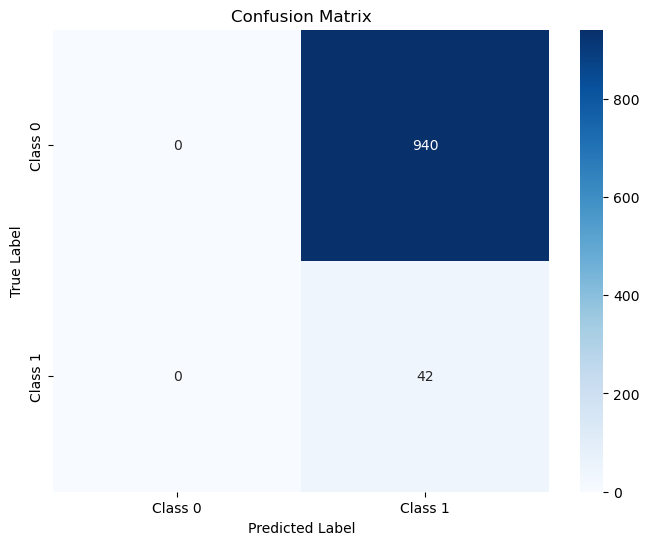

In [25]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

Wow! This is a complete flip of what I was seeing originally! This is exciting though, because it suggests that with tuning, I should be able to keep really good recall of class 1 while reducing errors for class 0. 

##  With Smote - Second set of numbers

In [26]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [27]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 20, 300, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 2, 25)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 1e-8, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 2, 500)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.4, 1.0)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.4, 1.0)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 20, 200)
    scale_pos_weight = trial.suggest_float('classifier__scale_pos_weight', 1, 100)
    learning_rate = trial.suggest_float('classifier__learning_rate', 0.01, 0.1)

    lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__boosting_type': boosting_type,
    'classifier__lambda_l1': lambda_l1,
    'classifier__lambda_l2': lambda_l2,
    'classifier__num_leaves': num_leaves,
    'classifier__feature_fraction': feature_fraction,
    'classifier__bagging_fraction': bagging_fraction,
    'classifier__bagging_freq': bagging_freq,
    'classifier__min_child_samples': min_child_samples,
    'classifier__scale_pos_weight': scale_pos_weight,
    'classifier__learning_rate': learning_rate
})

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]


        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:13:30,214] A new study created in memory with name: no-name-d12ec8da-95f1-42e0-b6e6-3fe9114bc8e1
[I 2024-04-14 12:13:32,045] Trial 0 finished with value: -0.6048456541510474 and parameters: {'classifier__n_estimators': 240, 'classifier__max_depth': 17, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.000539196671802286, 'classifier__lambda_l2': 1.6718743009830477, 'classifier__num_leaves': 160, 'classifier__feature_fraction': 0.6710626080711679, 'classifier__bagging_fraction': 0.5669855478106787, 'classifier__bagging_freq': 1, 'classifier__min_child_samples': 90, 'classifier__scale_pos_weight': 41.45024422729282, 'classifier__learning_rate': 0.08394493439783729}. Best is trial 0 with value: -0.6048456541510474.
[I 2024-04-14 12:13:34,191] Trial 1 finished with value: -0.4449908042621515 and parameters: {'classifier__n_estimators': 160, 'classifier__max_depth': 15, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.01997701543321918, 'classif

{'classifier__n_estimators': 40, 'classifier__max_depth': 3, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 9.172115240813605, 'classifier__lambda_l2': 1.7471130703130728e-05, 'classifier__num_leaves': 2, 'classifier__feature_fraction': 0.5629538947163624, 'classifier__bagging_fraction': 0.6511557261180054, 'classifier__bagging_freq': 4, 'classifier__min_child_samples': 59, 'classifier__scale_pos_weight': 65.37982466286711, 'classifier__learning_rate': 0.02927533700372254} 0.08158148965352734


In [28]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples'],
    'classifier__scale_pos_weight': best_params['classifier__scale_pos_weight'],
    'classifier__learning_rate': best_params['classifier__learning_rate']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [29]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.0428
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       940
           1       0.04      1.00      0.08        42

    accuracy                           0.04       982
   macro avg       0.02      0.50      0.04       982
weighted avg       0.00      0.04      0.00       982

[[  0 940]
 [  0  42]]


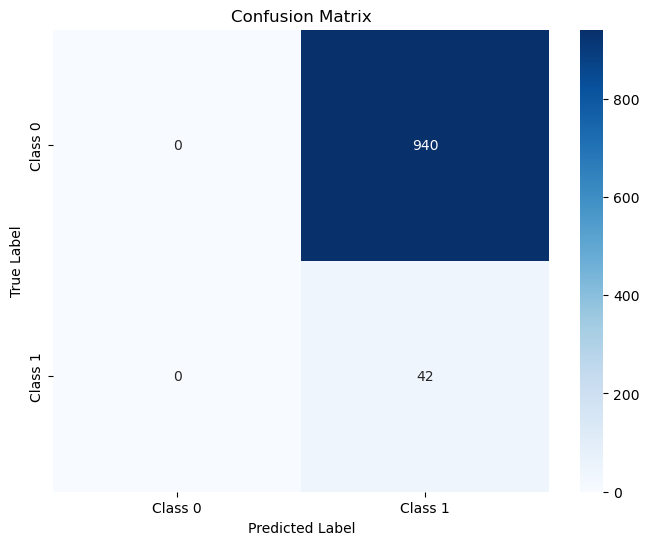

In [30]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

Using Smote without adjusting paramters keeps excellent recall for class 1 and reduces some of the errors for class 0. Let's see if I can get it even better. 

# Final Try

In [31]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [32]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 50, 250, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 3, 15)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 0.001, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 0.001, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 10, 200)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.5, .8)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.5, .8)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 30, 100)
    scale_pos_weight = trial.suggest_float('classifier__scale_pos_weight', 10, 50)
    learning_rate = trial.suggest_float('classifier__learning_rate', 0.01, 0.1)

    lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__boosting_type': boosting_type,
    'classifier__lambda_l1': lambda_l1,
    'classifier__lambda_l2': lambda_l2,
    'classifier__num_leaves': num_leaves,
    'classifier__feature_fraction': feature_fraction,
    'classifier__bagging_fraction': bagging_fraction,
    'classifier__bagging_freq': bagging_freq,
    'classifier__min_child_samples': min_child_samples,
    'classifier__scale_pos_weight': scale_pos_weight,
    'classifier__learning_rate': learning_rate
})

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]


        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:14:45,299] A new study created in memory with name: no-name-74f6cd2c-9dfb-4c03-920b-d9b0f22b9ea4
[I 2024-04-14 12:14:46,159] Trial 0 finished with value: -0.3351395136277032 and parameters: {'classifier__n_estimators': 190, 'classifier__max_depth': 12, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.0036523002189072546, 'classifier__lambda_l2': 0.5018530037393096, 'classifier__num_leaves': 84, 'classifier__feature_fraction': 0.7007573913801178, 'classifier__bagging_fraction': 0.7266729409758168, 'classifier__bagging_freq': 2, 'classifier__min_child_samples': 30, 'classifier__scale_pos_weight': 47.75100957426747, 'classifier__learning_rate': 0.04699303176894075}. Best is trial 0 with value: -0.3351395136277032.
[I 2024-04-14 12:14:46,787] Trial 1 finished with value: -0.3724774252324402 and parameters: {'classifier__n_estimators': 170, 'classifier__max_depth': 10, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.04196638236818528, 'classif

{'classifier__n_estimators': 90, 'classifier__max_depth': 3, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.27883074642732797, 'classifier__lambda_l2': 0.060598718361576286, 'classifier__num_leaves': 23, 'classifier__feature_fraction': 0.5540573316468429, 'classifier__bagging_fraction': 0.6296885397847322, 'classifier__bagging_freq': 4, 'classifier__min_child_samples': 94, 'classifier__scale_pos_weight': 42.96097292954874, 'classifier__learning_rate': 0.012412183137724936} 0.11182928798842817


In [33]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples'],
    'classifier__scale_pos_weight': best_params['classifier__scale_pos_weight'],
    'classifier__learning_rate': best_params['classifier__learning_rate']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [34]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.3432
              precision    recall  f1-score   support

           0       1.00      0.31      0.48       940
           1       0.06      1.00      0.12        42

    accuracy                           0.34       982
   macro avg       0.53      0.66      0.30       982
weighted avg       0.96      0.34      0.46       982

[[295 645]
 [  0  42]]


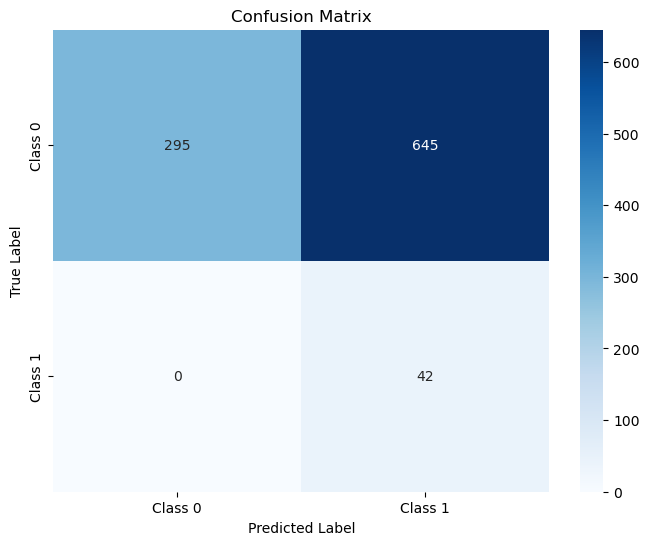

In [35]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

## With Smote - Final try

In [36]:
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols_feat)
])

lgbm_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('classifier', LGBMClassifier(class_weight="balanced",
            objective="binary", metric="binary_logloss",
            verbosity=-1))
])

In [37]:
def objective(trial):
    n_estimators = trial.suggest_int('classifier__n_estimators', 50, 250, step=20)
    max_depth = trial.suggest_int('classifier__max_depth', 3, 15)
    boosting_type = trial.suggest_categorical('classifier__boosting_type', ["gbdt"])
    lambda_l1 = trial.suggest_float('classifier__lambda_l1', 0.001, 10.0, log=True)
    lambda_l2 = trial.suggest_float('classifier__lambda_l2', 0.001, 10.0, log=True)
    num_leaves = trial.suggest_int('classifier__num_leaves', 10, 200)
    feature_fraction = trial.suggest_float('classifier__feature_fraction', 0.5, .8)
    bagging_fraction = trial.suggest_float('classifier__bagging_fraction', 0.5, .8)
    bagging_freq = trial.suggest_int('classifier__bagging_freq', 1, 7)
    min_child_samples = trial.suggest_int('classifier__min_child_samples', 30, 100)
    scale_pos_weight = trial.suggest_float('classifier__scale_pos_weight', 10, 50)
    learning_rate = trial.suggest_float('classifier__learning_rate', 0.01, 0.1)

    lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__boosting_type': boosting_type,
    'classifier__lambda_l1': lambda_l1,
    'classifier__lambda_l2': lambda_l2,
    'classifier__num_leaves': num_leaves,
    'classifier__feature_fraction': feature_fraction,
    'classifier__bagging_fraction': bagging_fraction,
    'classifier__bagging_freq': bagging_freq,
    'classifier__min_child_samples': min_child_samples,
    'classifier__scale_pos_weight': scale_pos_weight,
    'classifier__learning_rate': learning_rate
})

    scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_train_feat, y_train_feat):
        X_train, X_val = X_train_feat.iloc[train_index], X_train_feat.iloc[test_index]
        y_train, y_val = y_train_feat.iloc[train_index], y_train_feat.iloc[test_index]


        lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

        preds = lgbm_model_pipeline.predict(X_val)

        score = f1_score(y_val, preds)
        scores.append(score)

    return -np.mean(scores)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_score = -study.best_value

print(best_params, best_score)

[I 2024-04-14 12:15:23,849] A new study created in memory with name: no-name-486db0ab-5bfc-44c9-b9b0-e89c6d6ba35e
[I 2024-04-14 12:15:25,254] Trial 0 finished with value: -0.18265355371708206 and parameters: {'classifier__n_estimators': 170, 'classifier__max_depth': 12, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.0065506354431099, 'classifier__lambda_l2': 5.830214887448222, 'classifier__num_leaves': 27, 'classifier__feature_fraction': 0.7612015652151856, 'classifier__bagging_fraction': 0.5444564689105348, 'classifier__bagging_freq': 6, 'classifier__min_child_samples': 44, 'classifier__scale_pos_weight': 19.951808042214676, 'classifier__learning_rate': 0.01529819279767963}. Best is trial 0 with value: -0.18265355371708206.
[I 2024-04-14 12:15:27,607] Trial 1 finished with value: -0.8358201058201058 and parameters: {'classifier__n_estimators': 250, 'classifier__max_depth': 8, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 0.05432808383234495, 'classifie

{'classifier__n_estimators': 50, 'classifier__max_depth': 6, 'classifier__boosting_type': 'gbdt', 'classifier__lambda_l1': 7.968283721543106, 'classifier__lambda_l2': 9.991365025322283, 'classifier__num_leaves': 110, 'classifier__feature_fraction': 0.5036037185524617, 'classifier__bagging_fraction': 0.6699678446268079, 'classifier__bagging_freq': 3, 'classifier__min_child_samples': 73, 'classifier__scale_pos_weight': 47.052782671478795, 'classifier__learning_rate': 0.031035737528930664} 0.12787991973575638


In [38]:
best_params = study.best_params

lgbm_model_pipeline.set_params(**{
    'classifier__n_estimators': best_params['classifier__n_estimators'],
    'classifier__max_depth': best_params['classifier__max_depth'],
    'classifier__boosting_type': best_params['classifier__boosting_type'],
    'classifier__lambda_l1': best_params['classifier__lambda_l1'],
    'classifier__lambda_l2': best_params['classifier__lambda_l2'],
    'classifier__num_leaves': best_params['classifier__num_leaves'],
    'classifier__feature_fraction': best_params['classifier__feature_fraction'],
    'classifier__bagging_fraction': best_params['classifier__bagging_fraction'],
    'classifier__bagging_freq': best_params['classifier__bagging_freq'],
    'classifier__min_child_samples': best_params['classifier__min_child_samples'],
    'classifier__scale_pos_weight': best_params['classifier__scale_pos_weight'],
    'classifier__learning_rate': best_params['classifier__learning_rate']
})

lgbm_model_pipeline.fit(X_train_feat, y_train_feat)

y_pred_feat = lgbm_model_pipeline.predict(X_test_feat)

In [39]:
accuracy = accuracy_score(y_test_feat, y_pred_feat)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test_feat, y_pred_feat, zero_division=0)
print(report)

conf_matrix = confusion_matrix(y_test_feat, y_pred_feat)
print(conf_matrix)

Accuracy: 0.4226
              precision    recall  f1-score   support

           0       1.00      0.40      0.57       940
           1       0.07      0.98      0.13        42

    accuracy                           0.42       982
   macro avg       0.53      0.69      0.35       982
weighted avg       0.96      0.42      0.55       982

[[374 566]
 [  1  41]]


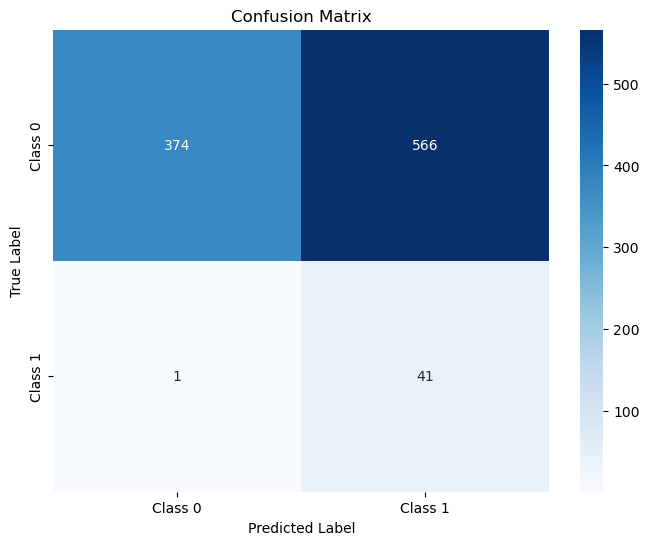

In [40]:
class_labels = ['Class 0', 'Class 1'] 
plot_confusion_matrix(conf_matrix, class_labels)

# Threshold Analysis


In [41]:
probabilities = lgbm_model_pipeline.predict_proba(X_test_feat)[:, 1]

In [42]:
fpr, tpr, thresholds = roc_curve(y_test_feat, probabilities)

roc_auc = auc(fpr, tpr)

In [43]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.8718691370946472


Okay! If the score of a patient is greater than or equal to 0.7316890791250177, classify the patient as having a stroke. If the score is less than 0.7316890791250177, classify the patient as not having a stroke.

In [44]:
y_prob = lgbm_model_pipeline.predict_proba(X_test_feat)[:, 1]  

In [45]:
roc_auc = roc_auc_score(y_test_feat, y_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.8089


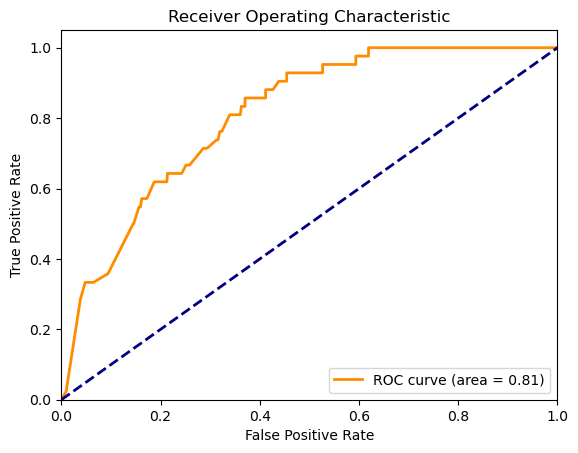

In [46]:
fpr, tpr, thresholds = roc_curve(y_test_feat, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Optimal threshold according to Youden's Index: 0.8718691370946472


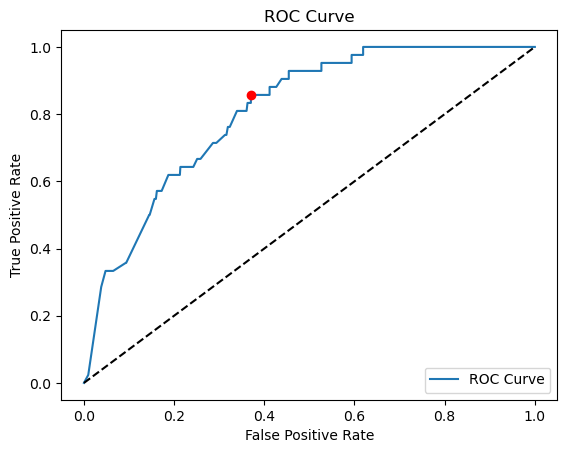

In [47]:
fpr, tpr, thresholds = roc_curve(y_test_feat, y_prob)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold according to Youden's Index:", optimal_threshold)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro') 
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

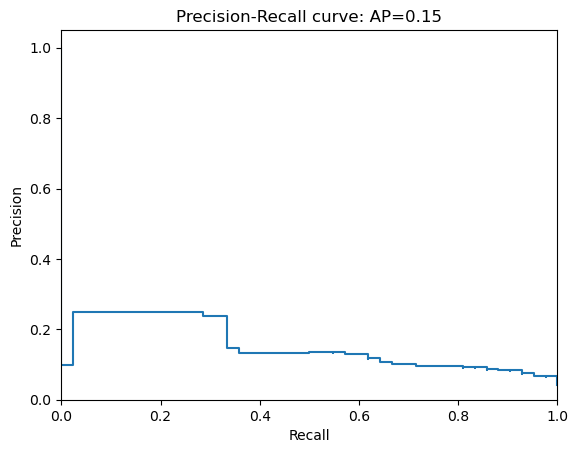

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test_feat, y_prob)
average_precision = average_precision_score(y_test_feat, y_prob)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()